In [1]:
!pip install vrplib

In [1]:
import collections
import datetime
import vrplib
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from typing import List

In [4]:
# vrplib.list_names(vrp_type="cvrp")

In [4]:
vrplib.download_instance("A-n32-k5", "A-n32-k5.vrp")
vrplib.download_solution("A-n32-k5", "A-n32-k5.sol")

In [5]:
instance = vrplib.read_instance("A-n32-k5.vrp")
solution = vrplib.read_solution("A-n32-k5.sol")

In [143]:
solution

{'routes': [[21, 31, 19, 17, 13, 7, 26],
  [12, 1, 16, 30],
  [27, 24],
  [29, 18, 8, 9, 22, 15, 10, 25, 5, 20],
  [14, 28, 11, 4, 23, 3, 2, 6]],
 'cost': 784}

In [6]:
instance

{'name': 'A-n32-k5',
 'comment': '(Augerat et al, No of trucks: 5, Optimal value: 784)',
 'type': 'CVRP',
 'dimension': 32,
 'edge_weight_type': 'EUC_2D',
 'capacity': 100,
 'node_coord': array([[82, 76],
        [96, 44],
        [50,  5],
        [49,  8],
        [13,  7],
        [29, 89],
        [58, 30],
        [84, 39],
        [14, 24],
        [ 2, 39],
        [ 3, 82],
        [ 5, 10],
        [98, 52],
        [84, 25],
        [61, 59],
        [ 1, 65],
        [88, 51],
        [91,  2],
        [19, 32],
        [93,  3],
        [50, 93],
        [98, 14],
        [ 5, 42],
        [42,  9],
        [61, 62],
        [ 9, 97],
        [80, 55],
        [57, 69],
        [23, 15],
        [20, 70],
        [85, 60],
        [98,  5]]),
 'demand': array([ 0, 19, 21,  6, 19,  7, 12, 16,  6, 16,  8, 14, 21, 16,  3, 22, 18,
        19,  1, 24,  8, 12,  4,  8, 24, 24,  2, 20, 15,  2, 14,  9]),
 'depot': array([0]),
 'edge_weight': array([[  0.        ,  34.92849839,  77.8

In [7]:
_x, _y = instance["node_coord"][:,0], instance["node_coord"][:,1]

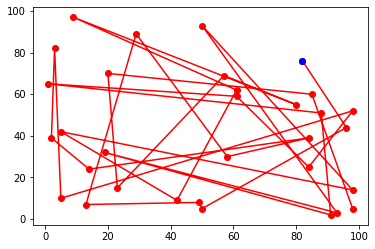

In [8]:
plt.plot(_x, _y, 'ro-')
plt.plot(_x[instance['depot']], _y[instance['depot']], 'bo')

In [9]:
_x[instance['depot']]

array([82])

In [10]:
np.sum(instance['demand'])

410

In [11]:
instance['demand'].shape

(32,)

In [12]:
instance['node_coord'].shape

(32, 2)

In [13]:
TEST_ROUTE_LENGTH = 5

In [14]:
route = instance['node_coord'][:TEST_ROUTE_LENGTH]

In [15]:
route = np.vstack( (route, instance['node_coord'][instance['depot']]) )

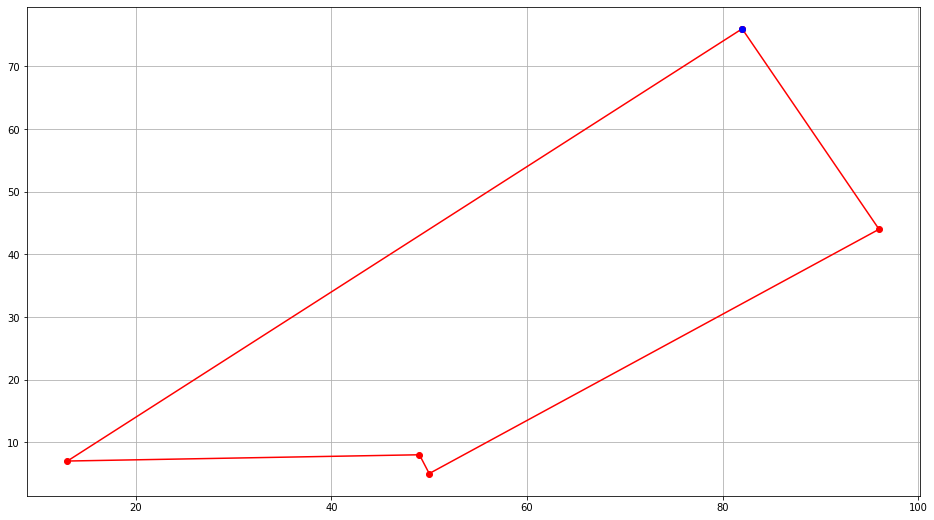

In [16]:
plt.figure(figsize=(16, 9))

plt.plot(route[:, 0], route[:, 1], 'ro-')
plt.plot(_x[instance['depot']], _y[instance['depot']], 'bo')

plt.grid()
plt.show()

---
### **Выполнение задачи. Инициализация решения.**
---

In [17]:
trucks = np.ceil(np.sum(instance['demand']) / instance['capacity']).astype(np.int32)
trucks

5

In [162]:
nodes = instance['node_coord']
demand = instance['demand']
edge_weight = instance['edge_weight']

In [59]:
def get_raw_routes() -> List[list]:
    routes = []

    free_nodes = set( [t[0] for t in list(enumerate(nodes))] )
    free_nodes.remove(0)

    for _ in range(trucks):
        cur_capacity = instance['capacity']
        idx = np.random.choice(list(free_nodes))
        route = []
        
        while (True):
            if demand[idx] <= cur_capacity and idx != -1:
                cur_capacity -= demand[idx]
                free_nodes.remove(idx)
                route.append(idx)
                idx = np.random.choice(list(free_nodes)) if len(free_nodes) != 0 else -1

            else:
                break
        
        routes.append(route)

    for i in range(len(routes)):
        routes[i] = [0] + routes[i] + [0]

    return routes

In [60]:
routes = get_raw_routes()
routes

[[0, 13, 20, 7, 19, 30, 29, 23, 0],
 [0, 6, 15, 8, 2, 4, 11, 0],
 [0, 16, 9, 26, 18, 22, 10, 3, 31, 28, 12, 0],
 [0, 1, 25, 14, 21, 24, 0],
 [0, 5, 17, 27, 0]]

In [168]:
def choose_nearest_node(node_idx : int, nodes_idxs : list):
    min_dist = np.inf
    nearest_node_idx = -1

    for free_node_idx in nodes_idxs:
        if free_node_idx == node_idx:
            continue
        
        if edge_weight[node_idx, free_node_idx] < min_dist:
            min_dist = edge_weight[node_idx, free_node_idx]
            nearest_node_idx = free_node_idx

    return nearest_node_idx

In [172]:
def get_greedy_routes() -> List[list]:
    routes = []

    free_nodes = set( [t[0] for t in list(enumerate(nodes))] )
    free_nodes.remove(0)

    for _ in range(trucks):
        cur_capacity = instance['capacity']
        idx = choose_nearest_node(0, list(free_nodes))
        route = []
        
        while (True):
            if demand[idx] <= cur_capacity and idx != -1:
                cur_capacity -= demand[idx]
                free_nodes.remove(idx)
                route.append(idx)
                idx = choose_nearest_node(idx, list(free_nodes))

            else:
                break
        
        routes.append(route)

    for i in range(len(routes)):
        routes[i] = [0] + routes[i] + [0]

    return routes

In [173]:
get_greedy_routes()

[[0, 30, 26, 16, 12, 1, 7, 0],
 [0, 24, 14, 27, 20, 5, 29, 15, 10, 0],
 [0, 13, 21, 31, 19, 17, 0],
 [0, 6, 3, 2, 23, 28, 8, 18, 22, 9, 0],
 [0, 25, 11, 4, 0]]

In [171]:
get_raw_routes()

[[0, 29, 1, 12, 13, 4, 8, 0],
 [0, 10, 14, 9, 19, 26, 17, 3, 0],
 [0, 21, 22, 5, 6, 16, 11, 27, 0],
 [0, 18, 24, 15, 2, 7, 28, 0],
 [0, 20, 31, 30, 23, 25, 0]]

In [26]:
target_function(routes)

2654.0877769795816

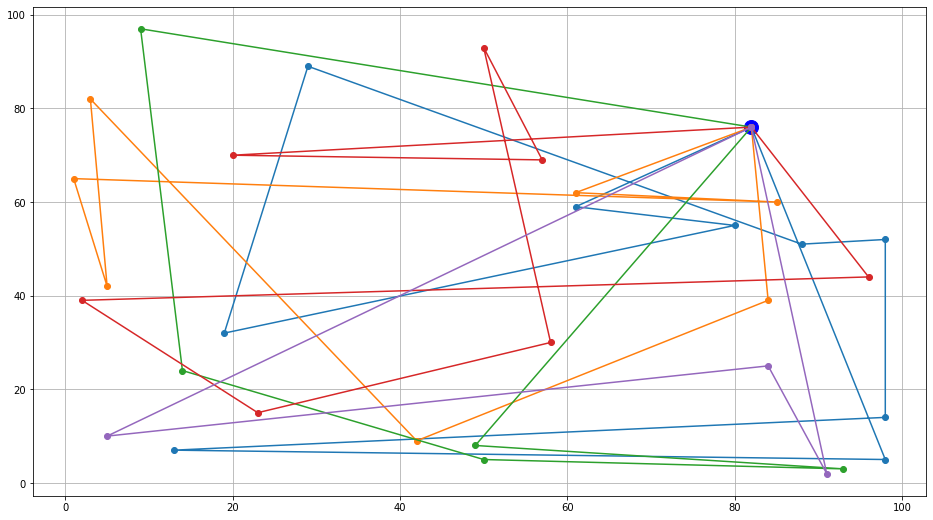

In [27]:
plt.figure(figsize=(16,9))
plt.plot(nodes[:,0][instance['depot']], nodes[:,1][instance['depot']], 'bo', markersize=14)

for route in routes:
    route_nodes = nodes[(route),:]
    plt.plot(route_nodes[:,0], route_nodes[:,1] , 'o-')


plt.grid()
plt.show()

In [85]:
nodes[(0, 1, 0),:]

array([[82, 76],
       [96, 44],
       [82, 76]])

In [28]:
routes

[[0, 31, 4, 21, 12, 16, 5, 18, 26, 14, 0],
 [0, 7, 23, 10, 22, 15, 30, 24, 0],
 [0, 25, 8, 2, 19, 3, 0],
 [0, 29, 27, 20, 6, 28, 9, 1, 0],
 [0, 11, 13, 17, 0]]

In [95]:
instance['edge_weight'].shape

(32, 32)

In [111]:
edge_weight[0,5]

54.57105459856901

In [101]:
[(routes[0][i], routes[0][i+1]) for i in range(len(routes[0])-1)]

[(0, 5), (5, 10), (10, 6), (6, 24), (24, 13), (13, 22), (22, 12), (12, 0)]

---
### **Целевая функция**
---

In [74]:
def target_function(routes : list):
    result = 0

    for route in routes:
        pairs = [(route[i], route[i+1]) for i in range(len(route)-1)]
        for pair in pairs:
            result += edge_weight[pair[0], pair[1]]

    return result

---
### **Расчёт решения из окрестности**
---

In [297]:
np.random.randint(0,2)

0

In [142]:
np.random.randint(1,5)

1

In [143]:
routes[0]

[0, 28, 9, 30, 23, 3, 19, 0]

In [65]:
def shuffle_order(routes : List[list]) -> List[list]:
    new_routes = deepcopy(routes)

    for i in range(len(new_routes)):
        if len(new_routes[i]) == 3:
            continue
        
        idx_1 = np.random.randint(1,len(new_routes[i])-1)
        idx_2 = np.random.randint(1,len(new_routes[i])-1)
        while idx_1 == idx_2:
            idx_2 = np.random.randint(1,len(new_routes[i])-1)
        
        new_routes[i][idx_1], new_routes[i][idx_2] = new_routes[i][idx_2], new_routes[i][idx_1]

    return new_routes

In [34]:
shuffled_routes = shuffle_order(routes)

print(target_function(shuffled_routes))
shuffled_routes

2814.359874773091


[[0, 31, 4, 26, 12, 16, 5, 18, 21, 14, 0],
 [0, 22, 23, 10, 7, 15, 30, 24, 0],
 [0, 19, 8, 2, 25, 3, 0],
 [0, 28, 27, 20, 6, 29, 9, 1, 0],
 [0, 11, 17, 13, 0]]

In [35]:
def is_valid_routes(routes : List[list]) -> bool:
    if len(routes) == 0:
        return False

    for route in routes:
        route_demand = 0
        for idx in route:
            route_demand += demand[idx]

        if route_demand > instance['capacity']:
            return False
    return True

In [36]:
def is_same_routes(routes_1 : List[list], routes_2 : List[list]):
    if len(routes_1) != len(routes_2):
        return False
    
    compare = lambda x, y: collections.Counter(x) == collections.Counter(y)

    checked_idxs_i = set()
    checked_idxs_j = set()
    for i in range(len(routes_1)):
        for j in range(len(routes_2)):
            if i in checked_idxs_i or j in checked_idxs_j:
                continue
            
            if compare(routes_1[i], routes_2[j]):
                checked_idxs_i.add(i)
                checked_idxs_j.add(j)
            else:
                if j == len(routes_2) - 1:
                    return False
    return True

In [37]:
def shuffle_verticies(routes : List[list]) -> List[list]:
    new_routes = []

    while not is_valid_routes(new_routes) or is_same_routes(routes, new_routes):
        new_routes = deepcopy(routes)
        route_idx_1 = np.random.randint(0,len(new_routes))
        route_idx_2 = np.random.randint(0,len(new_routes))
        while route_idx_1 == route_idx_2:
            route_idx_2 = np.random.randint(0,len(new_routes))

        random_idx_1 = np.random.randint(1,len(new_routes[route_idx_1])-1)
        random_idx_2 = np.random.randint(1,len(new_routes[route_idx_2]))
        # del new_routes[route_idx_2][-1]
        new_routes[route_idx_2] = new_routes[route_idx_2][:random_idx_2] + [new_routes[route_idx_1][random_idx_1]] + new_routes[route_idx_2][random_idx_2:] 
        del new_routes[route_idx_1][random_idx_1]
        # new_routes[route_idx_2].append(0)

    return new_routes

In [50]:
print(routes)
shuffled_routes = shuffle_verticies(routes)
print(shuffled_routes)
target_function(shuffled_routes)

[[0, 31, 4, 21, 12, 16, 5, 18, 26, 14, 0], [0, 7, 23, 10, 22, 15, 30, 24, 0], [0, 25, 8, 2, 19, 3, 0], [0, 29, 27, 20, 6, 28, 9, 1, 0], [0, 11, 13, 17, 0]]
[[0, 31, 4, 21, 12, 16, 5, 18, 29, 26, 14, 0], [0, 7, 23, 10, 22, 15, 30, 24, 0], [0, 25, 8, 2, 19, 3, 0], [0, 27, 20, 6, 28, 9, 1, 0], [0, 11, 13, 17, 0]]


2827.4263567282555

In [46]:
routes

[[0, 31, 4, 21, 12, 16, 5, 18, 26, 14, 0],
 [0, 7, 23, 10, 22, 15, 30, 24, 0],
 [0, 25, 8, 2, 19, 3, 0],
 [0, 29, 27, 20, 6, 28, 9, 1, 0],
 [0, 11, 13, 17, 0]]

In [51]:
def exchange_verticies(routes : List[list]) -> List[list]:
    new_routes = []

    while not is_valid_routes(new_routes) or is_same_routes(routes, new_routes):
        new_routes = deepcopy(routes)
        route_idx_1 = np.random.randint(0,len(new_routes))
        route_idx_2 = np.random.randint(0,len(new_routes))
        while route_idx_1 == route_idx_2:
            route_idx_2 = np.random.randint(0,len(new_routes))

        random_idx_1 = np.random.randint(1,len(new_routes[route_idx_1])-1)
        random_idx_2 = np.random.randint(1,len(new_routes[route_idx_2])-1)

        new_routes[route_idx_1][random_idx_1], new_routes[route_idx_2][random_idx_2] = new_routes[route_idx_2][random_idx_2], new_routes[route_idx_1][random_idx_1]


    return new_routes

In [52]:
print(routes)
shuffled_routes = exchange_verticies(routes)
print(shuffled_routes)
target_function(shuffled_routes)

[[0, 31, 4, 21, 12, 16, 5, 18, 26, 14, 0], [0, 7, 23, 10, 22, 15, 30, 24, 0], [0, 25, 8, 2, 19, 3, 0], [0, 29, 27, 20, 6, 28, 9, 1, 0], [0, 11, 13, 17, 0]]
[[0, 31, 4, 11, 12, 16, 5, 18, 26, 14, 0], [0, 7, 23, 10, 22, 15, 30, 24, 0], [0, 25, 8, 2, 19, 3, 0], [0, 29, 27, 20, 6, 28, 9, 1, 0], [0, 21, 13, 17, 0]]


2590.5895950526096

In [195]:
def get_near_sol(routes : List[list]) -> List[list]:
    is_transformed = False
    while not is_transformed:
        if (np.random.randint(0,2) == 1):
            routes = shuffle_order(routes)
            is_transformed = True
        if (np.random.randint(0,2) == 1):
            routes = shuffle_verticies(routes)
            is_transformed = True
        if (np.random.randint(0,2) == 1):
            routes = exchange_verticies(routes)
            is_transformed = True

    return routes

In [55]:
def plot_routes(routes : List[list]) -> None:
    plt.figure(figsize=(16,9))
    plt.plot(nodes[:,0][instance['depot']], nodes[:,1][instance['depot']], 'bo', markersize=14)

    for route in routes:
        route_nodes = nodes[(route),:]
        plt.plot(route_nodes[:,0], route_nodes[:,1] , 'o-')

    plt.title(f"Target function : {target_function(routes)}")
    plt.grid()
    plt.show()

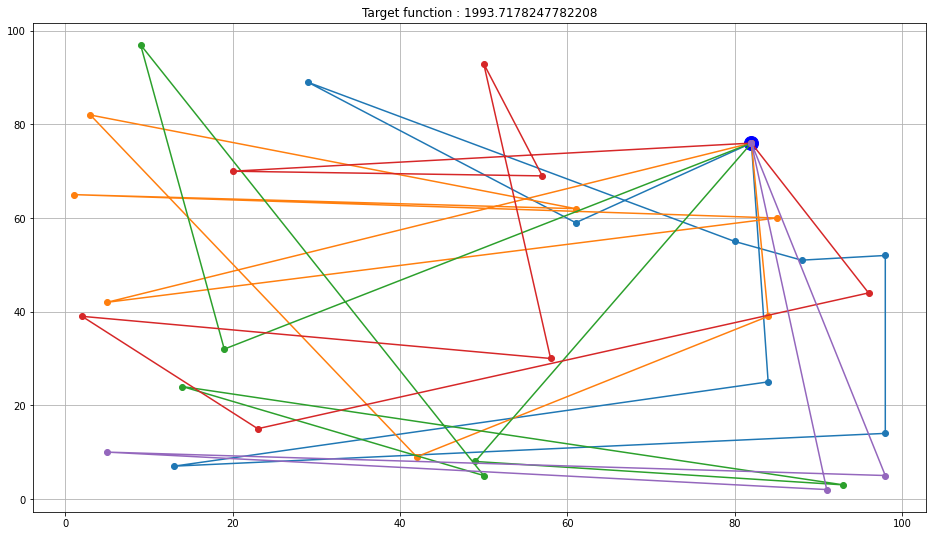

In [56]:
plot_routes(get_near_sol(routes))

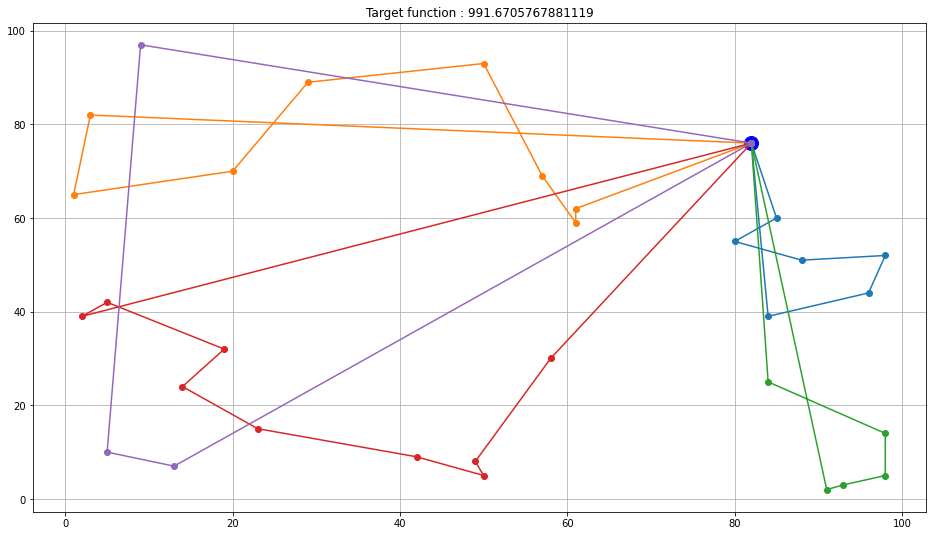

In [174]:
plot_routes(get_greedy_routes())

---
### **Алгоритм. Комбинированный детерминированный отжиг.**

---

In [382]:
EPOCHS = 2500

MAX_THETA = 50
MAX_ITERS_WITH_NO_INC = instance['dimension'] * 2

SUBSTRACTION_RATE = 1 / (instance['dimension'] * 4)

In [388]:
cur_solution = get_greedy_routes()
epochs = []
loss = []
min_solution = cur_solution
min_loss = np.inf

for _ in range(EPOCHS):
    theta = 0
    iter = 0

    min_cur_solution = cur_solution
    min_loss_cur = np.inf

    while iter < MAX_ITERS_WITH_NO_INC:
        new_solution = get_near_sol(cur_solution)
        
        if target_function(new_solution) - target_function(cur_solution) < theta:
            cur_solution = new_solution
            if  target_function(cur_solution) < min_loss_cur:
                min_cur_solution = deepcopy(cur_solution)
                min_loss_cur = target_function(cur_solution)

            iter = 0
        else:
            iter += 1
    
    theta = MAX_THETA * np.random.uniform(0,1)
    substraction = theta * SUBSTRACTION_RATE

    cur_solution = min_cur_solution
    while theta > 0:
        new_solution = get_near_sol(cur_solution)
        
        if target_function(new_solution) - target_function(cur_solution) < theta:
            cur_solution = new_solution
        else:
            theta -= substraction

    epoch_loss = target_function(cur_solution)
    epochs.append(_)
    loss.append(epoch_loss)

    if (epoch_loss < min_loss):
        min_loss = epoch_loss
        min_solution = cur_solution

In [393]:
cur_solution

[[0, 21, 17, 19, 31, 16, 0],
 [0, 18, 8, 11, 4, 28, 2, 3, 23, 0],
 [0, 12, 1, 7, 30, 24, 14, 0],
 [0, 26, 6, 13, 27, 0],
 [0, 20, 9, 22, 15, 10, 29, 25, 5, 0]]

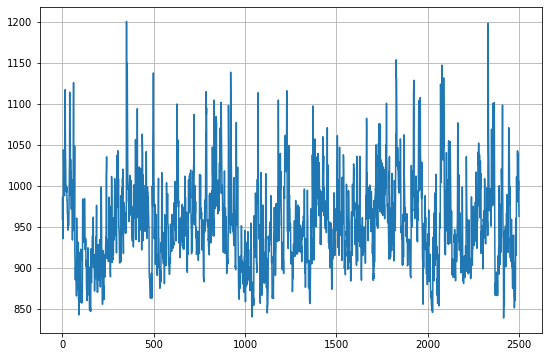

In [394]:
plt.figure(figsize=(9,6))
plt.plot(epochs, loss)

plt.grid()
plt.show()

In [395]:
min_solution

[[0, 24, 27, 0],
 [0, 14, 18, 8, 4, 11, 28, 23, 2, 3, 26, 0],
 [0, 12, 1, 16, 7, 30, 0],
 [0, 13, 21, 17, 31, 19, 6, 0],
 [0, 5, 29, 9, 22, 15, 10, 25, 20, 0]]

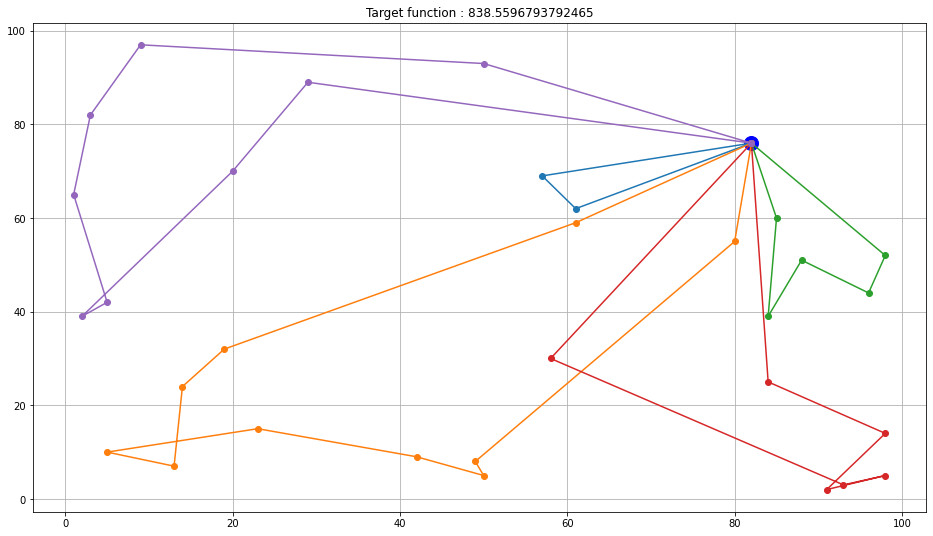

In [396]:
plot_routes(min_solution)

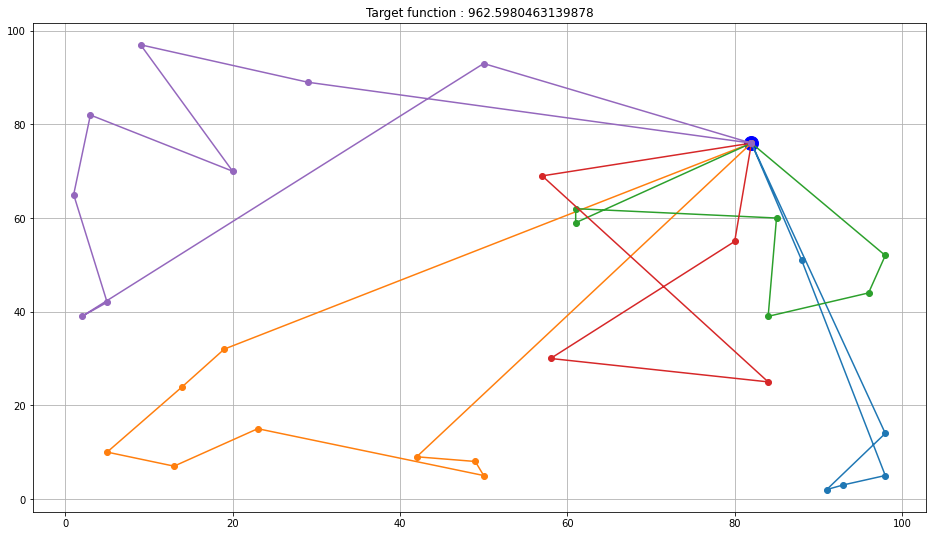

In [392]:
plot_routes(cur_solution)

---
### **Изучение групп Set A, Set B, Set E**
---
*B-n31-k5, E-n13-k4*

In [398]:
list_test = [1, 2, 3]

In [405]:
list(
    filter(
        lambda x : (str(x[0]) == 'A' or str(x[0]) == 'B' or str(x[0]) == 'E') and str(x[1]) == '-',
        vrplib.list_names(vrp_type="cvrp")
        )
    )

['A-n32-k5',
 'A-n33-k5',
 'A-n33-k6',
 'A-n34-k5',
 'A-n36-k5',
 'A-n37-k5',
 'A-n37-k6',
 'A-n38-k5',
 'A-n39-k5',
 'A-n39-k6',
 'A-n44-k6',
 'A-n45-k6',
 'A-n45-k7',
 'A-n46-k7',
 'A-n48-k7',
 'A-n53-k7',
 'A-n54-k7',
 'A-n55-k9',
 'A-n60-k9',
 'A-n61-k9',
 'A-n62-k8',
 'A-n63-k9',
 'A-n63-k10',
 'A-n64-k9',
 'A-n65-k9',
 'A-n69-k9',
 'A-n80-k10',
 'B-n31-k5',
 'B-n34-k5',
 'B-n35-k5',
 'B-n38-k6',
 'B-n39-k5',
 'B-n41-k6',
 'B-n43-k6',
 'B-n44-k7',
 'B-n45-k5',
 'B-n45-k6',
 'B-n50-k7',
 'B-n50-k8',
 'B-n51-k7',
 'B-n52-k7',
 'B-n56-k7',
 'B-n57-k7',
 'B-n57-k9',
 'B-n63-k10',
 'B-n64-k9',
 'B-n66-k9',
 'B-n67-k10',
 'B-n68-k9',
 'B-n78-k10',
 'E-n13-k4',
 'E-n22-k4',
 'E-n23-k3',
 'E-n30-k3',
 'E-n31-k7',
 'E-n33-k4',
 'E-n51-k5',
 'E-n76-k7',
 'E-n76-k8',
 'E-n76-k10',
 'E-n76-k14',
 'E-n101-k8',
 'E-n101-k14']

---
#### Set B example B-n31-k5
---

In [144]:
vrplib.download_instance("B-n31-k5", "B-n31-k5.vrp")
vrplib.download_solution("B-n31-k5", "B-n31-k5.sol")

In [145]:
instance_B = vrplib.read_instance("B-n31-k5.vrp")
solution_B = vrplib.read_solution("B-n31-k5.sol")

In [147]:
solution_B

{'routes': [[30, 23, 8, 12, 28, 26],
  [21, 16, 18, 25, 5, 4, 29],
  [7, 17, 13, 6, 9, 22],
  [20, 27, 10, 2],
  [14, 15, 11, 24, 19, 1, 3]],
 'cost': 672}

In [146]:
instance_B

{'name': 'B-n31-k5',
 'comment': '(Augerat et al, No of trucks: 5, Optimal value: 672)',
 'type': 'CVRP',
 'dimension': 31,
 'edge_weight_type': 'EUC_2D',
 'capacity': 100,
 'node_coord': array([[17, 76],
        [24,  6],
        [96, 29],
        [14, 19],
        [14, 32],
        [ 0, 34],
        [16, 22],
        [20, 26],
        [22, 28],
        [17, 23],
        [98, 30],
        [30,  8],
        [23, 27],
        [19, 23],
        [34,  7],
        [31,  7],
        [ 0, 37],
        [19, 23],
        [ 0, 36],
        [26,  7],
        [98, 32],
        [ 5, 40],
        [17, 26],
        [21, 26],
        [28,  8],
        [ 1, 35],
        [27, 28],
        [99, 30],
        [26, 28],
        [17, 29],
        [20, 26]]),
 'demand': array([ 0, 25,  3, 13, 17, 16,  9, 22, 10, 16,  8,  3, 16, 16, 10, 24, 16,
        15, 14,  5, 12,  2, 18, 20, 15,  8, 22, 15, 10, 13, 19]),
 'depot': array([0]),
 'edge_weight': array([[ 0.        , 70.34912935, 91.92388155, 57.07889277, 44.

---
#### Set E example E-n13-k4
---

In [148]:
vrplib.download_instance("E-n13-k4", "E-n13-k4.vrp")
vrplib.download_solution("E-n13-k4", "E-n13-k4.sol")

In [150]:
instance_E = vrplib.read_instance("E-n13-k4.vrp")
solution_E = vrplib.read_solution("E-n13-k4.sol")

In [151]:
solution_E

{'routes': [[1], [8, 5, 3], [9, 12, 10, 6], [11, 4, 7, 2]], 'cost': 247}

In [152]:
instance_E

{'name': 'E-n13-k4',
 'comment': '(Eilon et al, Min no of trucks: 4, Optimal value: 247)',
 'type': 'CVRP',
 'dimension': 13,
 'edge_weight_type': 'EXPLICIT',
 'edge_weight_format': 'LOWER_ROW',
 'display_data_type': 'NO_DISPLAY',
 'capacity': 6000,
 'edge_weight': array([[ 0.,  9., 14., 21., 23., 22., 25., 32., 36., 38., 42., 50., 52.],
        [ 9.,  0.,  5., 12., 22., 21., 24., 31., 35., 37., 41., 49., 51.],
        [14.,  5.,  0.,  7., 17., 16., 23., 26., 30., 36., 36., 44., 46.],
        [21., 12.,  7.,  0., 10., 21., 30., 27., 37., 43., 31., 37., 39.],
        [23., 22., 17., 10.,  0., 19., 28., 25., 35., 41., 29., 31., 29.],
        [22., 21., 16., 21., 19.,  0.,  9., 10., 16., 22., 20., 28., 30.],
        [25., 24., 23., 30., 28.,  9.,  0.,  7., 11., 13., 17., 25., 27.],
        [32., 31., 26., 27., 25., 10.,  7.,  0., 10., 16., 10., 18., 20.],
        [36., 35., 30., 37., 35., 16., 11., 10.,  0.,  6.,  6., 14., 16.],
        [38., 37., 36., 43., 41., 22., 13., 16.,  6.,  0., 1

---
# **Pipeline**
----

### CustomSolverCVRP

In [32]:
class CustomSolverCVRP:
    def __init__(self, instance : dict, solution : dict):
        self.instance = instance
        self.solution = solution

        self.trucks = np.ceil(np.sum(self.instance['demand']) / self.instance['capacity']).astype(np.int32)
        print(f"Calculated trucks : {self.trucks}")
        
        self.can_plot = True
        if self.instance.get('node_coord') is None:
            self.nodes = np.zeros((self.instance['dimension'], 2))
            self.can_plot = False
        else:
            self.nodes = self.instance['node_coord']
        self.demand = self.instance['demand']
        self.edge_weight = self.instance['edge_weight']

        self.epochs = 15000
        self.max_theta = 50
        self.max_with_no_inc = 20
        self.substraction_rate = 1e-1 #1 / (self.instance['dimension'] * 2)
        
        self.buffer_routes = []
        self.buffer_routes_bad = []


    def choose_nearest_node(self, node_idx : int, nodes_idxs : list):
        min_dist = np.inf
        nearest_node_idx = -1

        for free_node_idx in nodes_idxs:
            if free_node_idx == node_idx:
                continue
            
            if self.edge_weight[node_idx, free_node_idx] < min_dist:
                min_dist = self.edge_weight[node_idx, free_node_idx]
                nearest_node_idx = free_node_idx

        return nearest_node_idx

    

    def get_greedy_routes(self) -> List[list]:
        routes = []

        free_nodes = set( [t[0] for t in list(enumerate(self.nodes))] )
        free_nodes.remove(0)

        for _ in range(self.trucks):
            cur_capacity = self.instance['capacity']
            idx = self.choose_nearest_node(0, list(free_nodes))
            route = []
            
            while (True):
                if self.demand[idx] <= cur_capacity and idx != -1:
                    cur_capacity -= self.demand[idx]
                    free_nodes.remove(idx)
                    route.append(idx)
                    idx = self.choose_nearest_node(idx, list(free_nodes))

                else:
                    break

            routes.append(route)

        for i in range(len(routes)):
            routes[i] = [self.instance['depot'][0]] + routes[i] + [self.instance['depot'][0]]

        return routes
    
    
    def shuffle_order(self, routes : List[list]) -> List[list]:
        new_routes = deepcopy(routes)

        for i in range(len(new_routes)):
            if len(new_routes[i]) <= 3:
                continue
            
            # print(new_routes[i])
            idx_1 = np.random.randint(1,len(new_routes[i])-1)
            idx_2 = np.random.randint(1,len(new_routes[i])-1)
            while idx_1 == idx_2:
                idx_2 = np.random.randint(1,len(new_routes[i])-1)
            
            new_routes[i][idx_1], new_routes[i][idx_2] = new_routes[i][idx_2], new_routes[i][idx_1]

        return new_routes

    
    def is_valid_routes(self, routes : List[list]) -> bool:
        if len(routes) == 0:
            return False

        for route in routes:
            route_demand = 0
            for idx in route:
                route_demand += self.demand[idx]

            if route_demand > self.instance['capacity']:
                return False
        return True


    def is_same_routes(self, routes_1 : List[list], routes_2 : List[list]):
        if len(routes_1) != len(routes_2):
            return False
        
        compare = lambda x, y: collections.Counter(x) == collections.Counter(y)

        checked_idxs_i = set()
        checked_idxs_j = set()
        for i in range(len(routes_1)):
            for j in range(len(routes_2)):
                if i in checked_idxs_i or j in checked_idxs_j:
                    continue
                
                if compare(routes_1[i], routes_2[j]):
                    checked_idxs_i.add(i)
                    checked_idxs_j.add(j)
                else:
                    if j == len(routes_2) - 1:
                        return False
        return True


    def shuffle_verticies(self, routes : List[list]) -> List[list]:
        new_routes = []

        while not self.is_valid_routes(new_routes) or self.is_same_routes(routes, new_routes):
            new_routes = deepcopy(routes)
            route_idx_1 = np.random.randint(0,len(new_routes))
            route_idx_2 = np.random.randint(0,len(new_routes))
            while route_idx_1 == route_idx_2 or len(new_routes[route_idx_1]) < 3 or len(new_routes[route_idx_2]) < 3:
                route_idx_1 = np.random.randint(0,len(new_routes))
                route_idx_2 = np.random.randint(0,len(new_routes))

            # print(new_routes[route_idx_1])
            # print(new_routes[route_idx_2])
            if len(new_routes[route_idx_1])-1 == 1:
                random_idx_1 = 1
            else:
                random_idx_1 = np.random.randint(1,len(new_routes[route_idx_1])-1)
            random_idx_2 = np.random.randint(1,len(new_routes[route_idx_2]))
            new_routes[route_idx_2] = new_routes[route_idx_2][:random_idx_2] + [new_routes[route_idx_1][random_idx_1]] + new_routes[route_idx_2][random_idx_2:] 
            del new_routes[route_idx_1][random_idx_1]

        return new_routes

    
    def exchange_verticies(self, routes : List[list]) -> List[list]:
        new_routes = []

        while not self.is_valid_routes(new_routes) or self.is_same_routes(routes, new_routes):
            new_routes = deepcopy(routes)
            route_idx_1 = np.random.randint(0,len(new_routes))
            route_idx_2 = np.random.randint(0,len(new_routes))
            while route_idx_1 == route_idx_2 or len(new_routes[route_idx_1]) < 3 or len(new_routes[route_idx_2]) < 3:
                route_idx_1 = np.random.randint(0,len(new_routes))
                route_idx_2 = np.random.randint(0,len(new_routes))
            

            # print(new_routes[route_idx_1])
            # print(new_routes[route_idx_2])
            if len(new_routes[route_idx_1])-1 == 1:
                random_idx_1 = 1
            else:
                random_idx_1 = np.random.randint(1,len(new_routes[route_idx_1])-1)
            if len(new_routes[route_idx_2])-1 == 1:
                random_idx_2 = 1
            else:
                random_idx_2 = np.random.randint(1,len(new_routes[route_idx_2])-1)

            new_routes[route_idx_1][random_idx_1], new_routes[route_idx_2][random_idx_2] = new_routes[route_idx_2][random_idx_2], new_routes[route_idx_1][random_idx_1]

        return new_routes
    

    def get_near_sol(self, routes : List[list], bad : bool) -> List[list]:
#         is_transformed = False
#         while not is_transformed:
#             if (np.random.randint(0,2) == 1):
#                 routes = self.shuffle_order(routes)
#                 is_transformed = True
#             if (np.random.randint(0,2) == 1):
#                 routes = self.shuffle_verticies(routes)
#                 is_transformed = True
#             if (np.random.randint(0,2) == 1):
#                 routes = self.exchange_verticies(routes)
#                 is_transformed = True
        first_run = True
        transform_case = np.random.randint(0,3)
        while first_run or ( (routes in self.buffer_routes) ^ (routes in self.buffer_routes_bad)):
            if transform_case == 0:
                routes = self.shuffle_order(routes)
            if transform_case == 1:
                routes = self.shuffle_verticies(routes)
            if transform_case == 2:
                routes = self.exchange_verticies(routes)
            first_run = False
            
        return routes

    
    def target_function(self, routes : list):
        result = 0

        for route in routes:
            pairs = [(route[i], route[i+1]) for i in range(len(route)-1)]
            for pair in pairs:
                result += self.edge_weight[pair[0], pair[1]]

        return result


    def run_algorithm(self):
        self.buffer_routes = []
        self.buffer_routes_bad = []
        start = datetime.datetime.now()

        cur_solution = self.get_greedy_routes()
        # print(cur_solution)
        epoch = []
        loss = []
        min_solution = cur_solution
        min_loss = np.inf

        for _ in range(self.epochs):
            theta = 0
            iter = 0

            min_cur_solution = cur_solution
            min_loss_cur = np.inf

            while iter < self.max_with_no_inc:
                new_solution = self.get_near_sol(cur_solution, bad=False)
                self.buffer_routes.append(new_solution)
                
                if self.target_function(new_solution) - self.target_function(cur_solution) < theta:
                    cur_solution = new_solution
                    if  self.target_function(cur_solution) < min_loss_cur:
                        min_cur_solution = deepcopy(cur_solution)
                        min_loss_cur = self.target_function(cur_solution)

                    iter = 0
                else:
                    iter += 1
            
            theta = self.max_theta * np.random.uniform(0,1)
            substraction = theta * self.substraction_rate

            cur_solution = min_cur_solution
            while theta > 0:
                new_solution = self.get_near_sol(cur_solution, bad=True)
                self.buffer_routes_bad.append(new_solution)
                
                if self.target_function(new_solution) - self.target_function(cur_solution) < theta:
                    cur_solution = new_solution
                else:
                    theta -= substraction

            epoch_loss = self.target_function(cur_solution)
            epoch.append(_)
            loss.append(epoch_loss)

            if (epoch_loss < min_loss):
                min_loss = epoch_loss
                min_solution = cur_solution

        elapsed_time = str(datetime.datetime.now() - start)
        self.x_ = epoch
        self.y_ = loss

        return min_solution, min_loss, elapsed_time


    def plot_routes(self, routes : List[list]) -> None:
        if not self.can_plot:
            return
        plt.figure(figsize=(16,9))
        plt.plot(self.nodes[:,0][self.instance['depot']], self.nodes[:,1][self.instance['depot']], 'bo', markersize=14)

        for route in routes:
            route_nodes = self.nodes[(route),:]
            plt.plot(route_nodes[:,0], route_nodes[:,1] , 'o-')

        plt.title(f"Target function : {self.target_function(routes)}")
        plt.grid()
        plt.show()

In [5]:
sample_list = list(
    filter(
        lambda x : (str(x[0]) == 'A' or str(x[0]) == 'B' or str(x[0]) == 'E') and str(x[1]) == '-',
        vrplib.list_names(vrp_type="cvrp")
        )
    )

In [3]:
sample_list_E = list(
    filter(
        lambda x : (str(x[0]) == 'E') and str(x[1]) == '-',
        vrplib.list_names(vrp_type="cvrp")
        )
    )

### Processing

In [2]:
import pandas as pd

In [33]:
df_dict = {'sample' : [], 'elapsed_time' : [], 'mape' : [], 'dimension' : [], 'type' : []}
for sample in sample_list:
    vrplib.download_instance(sample, f"data/{sample}.vrp")
    vrplib.download_solution(sample, f"data/{sample}.sol")

    instance_ = vrplib.read_instance(f"data/{sample}.vrp")
    solution_ = vrplib.read_solution(f"data/{sample}.sol")
    
    df_dict['dimension'].append(instance_['dimension'])
    df_dict['type'].append(sample[0])

    solver = CustomSolverCVRP(instance_, solution_)
    solver_solution, loss, elapsed_time = solver.run_algorithm()

    mape = round(100*np.abs((solution_['cost'] - loss)/solution_['cost']), ndigits=2)
    
    df_dict['sample'].append(sample)
    df_dict['elapsed_time'].append(elapsed_time)
    df_dict['mape'].append(mape)

    print(f"{sample}, elapsed_time = {elapsed_time}, mape = {mape}%")
    solver.plot_routes(solver_solution)
    
    print("Original")
    original_solution = solution_['routes']
    for i in range(len(original_solution)):
        original_solution[i] = [0] + original_solution[i] + [0]

    solver.plot_routes(original_solution)

df = pd.DataFrame(df_dict)
df.to_csv("result/cvrp_da_new_2.csv", index=False)

Calculated trucks : 5


KeyboardInterrupt: 

In [33]:
df_dict['mape'][-1]

3.46

In [32]:
df = pd.DataFrame(df_dict)
df.to_csv("result/cvrp_da.csv", index=False)